<h1 style='text-align: center;'>LSB steganography</h1>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
from skimage.color import rgb2gray

## Task 1: LSB extraction and re-insertion

In [2]:
# 1.1. Read a color image and convert it to grayscale
I = Image.open('lena256.png').convert('L')  # Convert to grayscale
G = np.array(I)

I


In [3]:
# 1.2. Extract the k=8 bit-planes of the image

def get_bit_planes(G):
    # Initialize the bitplane container
    rows, cols = G.shape
    planes = np.zeros((rows, cols, 8), dtype=int)

    # Convert each pixel to binary and populate the bitplanes
    for i in range(rows):
        for j in range(cols):
            binary_pixel = format(G[i, j], '08b')  # Convert pixel value to an 8-bit binary string
            for k, bit in enumerate(binary_pixel):
                planes[i, j, k] = int(bit)
    
    return planes

planes = get_bit_planes(G)

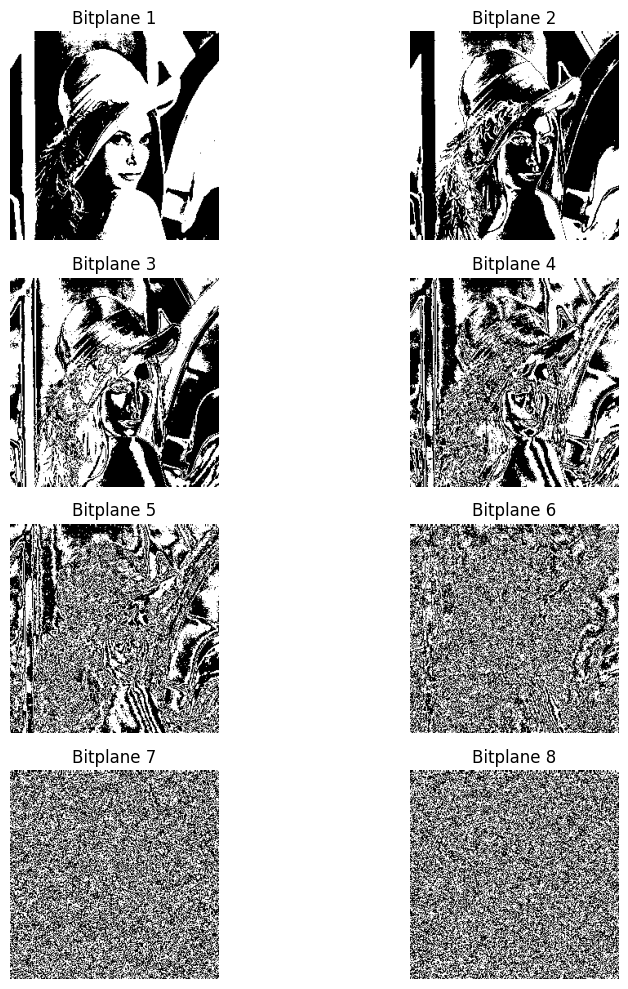

In [4]:
# 1.3. Display each bit-plane of the image

fig, axes = plt.subplots(4, 2, figsize=(10, 10))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(planes[:, :, i], cmap='gray')
    axes[i].set_title(f'Bitplane {i + 1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

We can observe here that MSB can well describe the image, so if we change it to another value it will be visible. At the same time LSB represent some noise, so in case of modification it won't significatly impact the image.

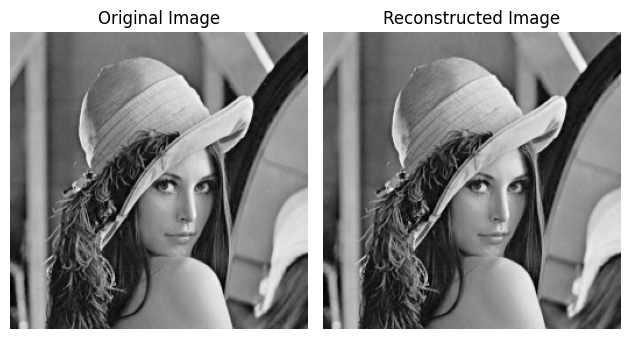

In [5]:
# 1.4. Reconstruct the grayscale image

def reconstruct_from_bitplanes(planes):
    rows, cols, _ = planes.shape
    
    G_rec = np.zeros((rows, cols), dtype=np.uint8)

    for i in range(rows):
        for j in range(cols):
            # Extract bits of the current pixel
            binary_pixel = planes[i, j, :]
            
            # Reverse the bits (LSB to MSB)
            binary_pixel = binary_pixel[::-1]
            
            # Convert binary array to decimal
            decimal_value = sum([bit * (2 ** idx) for idx, bit in enumerate(binary_pixel)])
            G_rec[i, j] = decimal_value

    return G_rec

G_rec = reconstruct_from_bitplanes(planes)

# Compare original and reconstructed images
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(G, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(G_rec, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

This code shows that we can inverse the processus of bitplanes creation to initial image.

In [6]:
# 1.5. Save the modified image

G_rec_save = Image.fromarray(np.uint8(G_rec))
G_rec_save.save('lena256_task1.png', 'PNG')

## Task 2: Embedding a message into the LSB

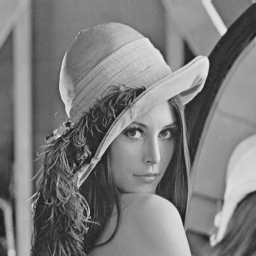

In [7]:
# 2.1. Read a color image and convert it to grayscale

I2 = Image.open('lena256.png').convert('L')  # Convert to grayscale
G2 = np.array(I2)

I2

In [8]:
# 2.2. Extract the k bit-planes of the image

planes = get_bit_planes(G2)

In [9]:
# 2.3. Convert a string into a binary message of length L

def string_to_binary(message):
    binary_representation = ''.join(format(ord(char), '08b') for char in message)
    
    return binary_representation

def binary_to_string(message_bin):
    byte_chunks = [message_bin[i:i+8] for i in range(0, len(message_bin), 8)]
    characters = [chr(int(byte, 2)) for byte in byte_chunks]
    
    return ''.join(characters)

message_bin = 'Hello'
message_bin = string_to_binary(message_bin)

message_bin

'0100100001100101011011000110110001101111'

In [10]:
# 2.4. Insert the message into random positions of the LSB

def hide_message(message_bin, planes, key):
    np.random.seed(key)
    pos = [(i,j) for i in range(planes.shape[0]) for j in range(planes.shape[1])]
    idx_random_pos = np.random.choice(len(pos), len(message_bin), replace=False)
    random_pos = [pos[idx] for idx in idx_random_pos]

    for bit, p in zip(message_bin, random_pos) :
        planes[p[0],p[1],7] = bit
        
    return planes

secret_key = 123456789
planes2 = hide_message(message_bin, planes, secret_key)


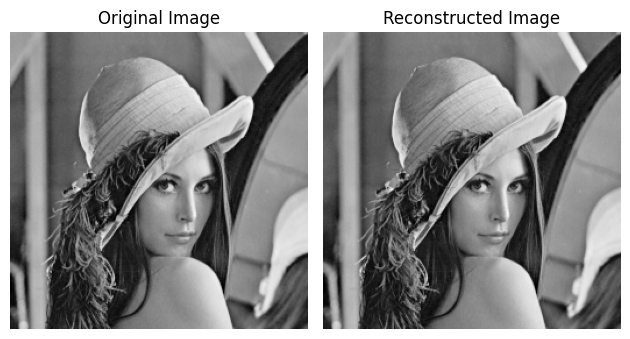

In [11]:
# 2.5. Reconstruct the image and save it

G2_rec = reconstruct_from_bitplanes(planes2)

G2_rec_save = Image.fromarray(np.uint8(G2_rec))
G2_rec_save.save('lena256_task2.png', 'PNG')

# Compare original and reconstructed images
plt.figure('Original vs Reconstructed')
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(G2, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Reconstructed Image')
plt.imshow(G2_rec, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# 2.6. Extract the LSB of the modified (stego) image

def retrieve_message(image_bin, L, key):
    np.random.seed(key)
    # generating L distinct random positions
    pos_steg = [(i,j) for i in range(image_bin.shape[0]) for j in range(image_bin.shape[1])]
    idx_random_pos_steg = np.random.choice(len(pos_steg), L, replace=False)
    random_pos_steg = [pos_steg[ind] for ind in idx_random_pos_steg]

    # generating the plane to get a matrix with only LSB, for facility
    plane_steg = get_bit_planes(image_bin)

    # extracting the LSB of the modified image to get the message
    mess_extract = []
    for p in random_pos_steg :
        mess_extract.append(plane_steg[p[0],p[1],7].astype(np.uint8).astype(str))

    mess_extract = ''.join(mess_extract)
    
    return mess_extract

# Using same key and same L
mess_extract = retrieve_message(G2_rec, len(message_bin), secret_key)

print(f"Message extracted : {binary_to_string(mess_extract)}")

# Comparing with input message :
errors = bin(int(mess_extract,2) ^ int(message_bin,2)).count('1')
print(f'Number of errors between bits of the original message and extracted message : {errors}')

Message extracted : Hello
Number of errors between bits of the original message and extracted message : 0


Pixel wise:


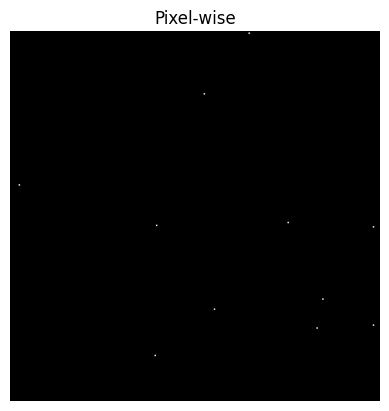


Distortion:
23

PSNR:
190.37387763346828

SSIM:
0.9999979259471016


In [13]:
# 2.7. Compare the cover image x and the modified stego image y

def compare_images(g1, g2, color = False):
    # Color
    if color is True:
        delta = np.zeros((g1.shape[0],g1.shape[1]))
        for i in range(g1.shape[0]):
            for j in range(g1.shape[1]):
                delta[i,j] = np.sqrt(((g1[i,j,0]-g2[i,j,0])**2)+((g1[i,j,1]-g2[i,j,1])**2)+((g1[i,j,2]-g2[i,j,2])**2))

        plt.title("Color difference ")
        plt.imshow(delta)
        plt.axis('off')
        plt.show() 
        
    else:
        # Pixel-wise
        def pixel_wise(G, G_rec):
            pixel_wise = np.abs(G - G_rec)  

            # Combine unique values and counts into a dictionary
            return pixel_wise

        print('Pixel wise:')

        plt.title("Pixel-wise")
        plt.imshow(pixel_wise(g1, g2),cmap='gray')
        plt.axis('off')
        plt.show()

        # Distortion
        def distortion(G, G_rec):
            return np.sum((G - G_rec)**2)

        print('\nDistortion:')
        print(distortion(g1, g2))

        # PSNR
        def psnr(G, G_rec):
            m, n = G.shape
            mse = distortion(G, G_rec) / (m * n)

            return 20 * np.log(255) - 10 * np.log(mse)

        print('\nPSNR:')
        print(psnr(g1, g2))

        # SSIM
        print('\nSSIM:')
        print(ssim(g1, g2, full=True)[0])

compare_images(G2, G2_rec)

We can see the modified pixels on the pixel-wise image

## Task 3: Embedding of binary image into LSB

In [14]:
# 3.1. Read a color cover image of size [M,N]

I3 = Image.open('lena256.png')
G3 = np.array(I3)

I3

In [15]:
# 3.2. Read a grayscale secret image of size [M,N] and make it binary

I3_secret = Image.open('che.jpg').convert('L')
G3_secret = np.array(I3_secret)
G3_secret_bin = (G3_secret > 127).astype(np.uint8)

plt.figure(figsize=(10,5))

plt.subplot(121).set_title(f'Grayscale secret image of size {G3_secret.shape}')
plt.imshow(G3_secret, cmap='gray')
plt.axis('off')

plt.subplot(122).set_title(f'Grayscale secret image binary')
plt.imshow(G3_secret_bin, cmap='gray')
plt.axis('off')

plt.show()

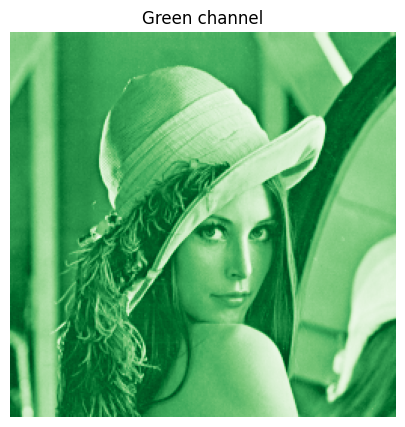

In [16]:
# 3.3. Extract the channel (e.g. green) where the message is embedded

# Extract green channel
green_channel = G3[:,:,1]

plt.figure(figsize=(10,5))

plt.title(f'Green channel')
plt.imshow(green_channel, cmap='Greens_r')
plt.axis('off')

plt.show()

In [17]:
# 3.4. Get the LSB plane of the green channel 

# LSB plane of green channel
green_planes = get_bit_planes(green_channel)

In [18]:
# 3.5. Replace the LSB with the secret image

# Replace LSB with secret image
green_planes[:,:,7] = G3_secret_bin

In [19]:
# 3.6. Reconstruct the green channel green_mod

# Reconstruct the green channel
green_channel_rec = reconstruct_from_bitplanes(green_planes)

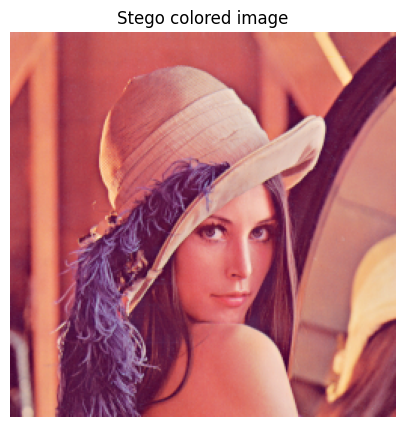

In [20]:
# 3.7. Reconstruct the stego color image and save it in TIFF format

# Reconstruct the stego color image
stego_img_green= np.stack((G3[:,:,0], green_channel_rec, G3[:,:,2]), axis=2)

stego_img_green_save = Image.fromarray(np.uint8(stego_img_green))
stego_img_green_save.save('lena256_task3_green.tiff', format='TIFF')

plt.figure(figsize=(10,5))

plt.title(f'Stego colored image')
plt.imshow(stego_img_green)
plt.axis('off')

plt.show()

------------------------------------------------------------------------------------------
Red
Pixel wise:


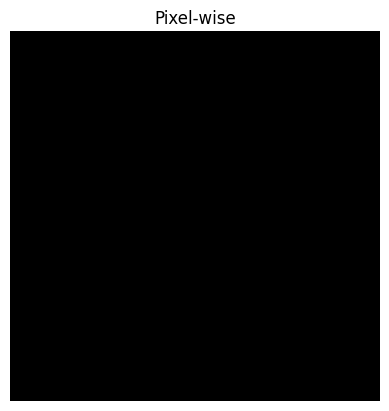


Distortion:
0

PSNR:
inf

SSIM:
1.0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Green
Pixel wise:


/var/folders/5j/qcktt86s72lf8z5jyddn8yr80000gq/T/ipykernel_71439/416643551.py:43: RuntimeWarning: divide by zero encountered in log
  return 20 * np.log(255) - 10 * np.log(mse)


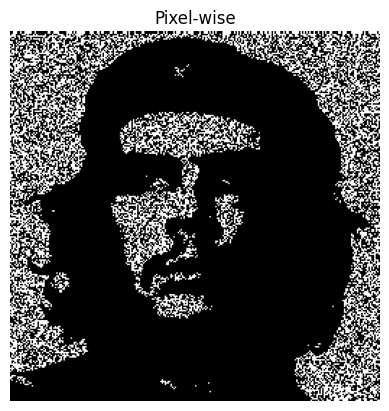


Distortion:
32880

PSNR:
117.72262130105861

SSIM:
0.9984592584806627
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Blue
Pixel wise:


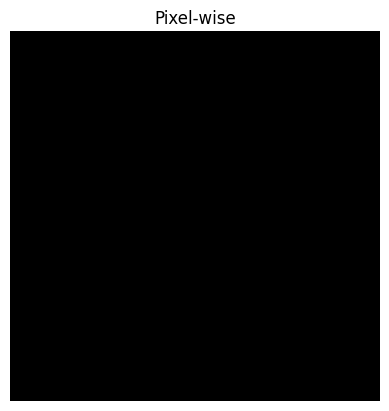


Distortion:
0

PSNR:
inf

SSIM:
1.0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Color delta


/var/folders/5j/qcktt86s72lf8z5jyddn8yr80000gq/T/ipykernel_71439/416643551.py:9: RuntimeWarning: overflow encountered in scalar subtract
  delta[i,j] = np.sqrt(((g1[i,j,0]-g2[i,j,0])**2)+((g1[i,j,1]-g2[i,j,1])**2)+((g1[i,j,2]-g2[i,j,2])**2))


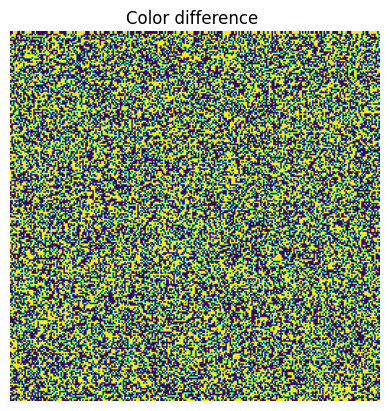

In [21]:
# 3.8. Compare each channel of the cover image x and the modified stego image y

# Compare red
print('---'*30)
print('Red')
compare_images(G3[:,:,0], stego_img_green[:,:,0])
print('---'*30)

# Compare green
print('---'*30)
print('Green')
compare_images(G3[:,:,1], stego_img_green[:,:,1])
print('---'*30)

# Compare blue
print('---'*30)
print('Blue')
compare_images(G3[:,:,2], stego_img_green[:,:,2])
print('---'*30)

# Compare color
print('---'*30)
print('Color delta')
compare_images(G3, stego_img_green, color=True)

We can see the hidden image in the green channel, as expected. At the same time 2 other channels weren't inpacted

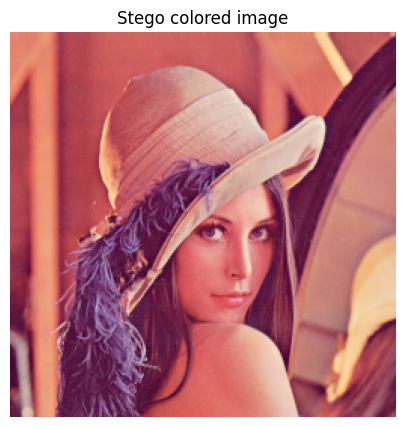

In [22]:
# 3.9. Repeat the embedding procedure on a different channel (red, blue) and compute again the above metrics. Indicate the difference

# Red channel

red_channel = G3[:,:,0]
red_planes = get_bit_planes(red_channel)
red_planes[:,:,7] = G3_secret_bin
red_channel_rec = reconstruct_from_bitplanes(red_planes)
stego_img_red = np.stack((red_channel_rec, G3[:,:,1], G3[:,:,2]), axis=2)

plt.figure(figsize=(10,5))

plt.title(f'Stego colored image')
plt.imshow(stego_img_red)
plt.axis('off')

plt.show()

------------------------------------------------------------------------------------------
Red
Pixel wise:


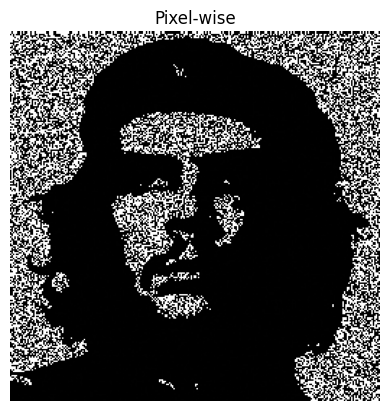


Distortion:
32927

PSNR:
117.7083371039393

SSIM:
0.9980882630013439
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Green
Pixel wise:


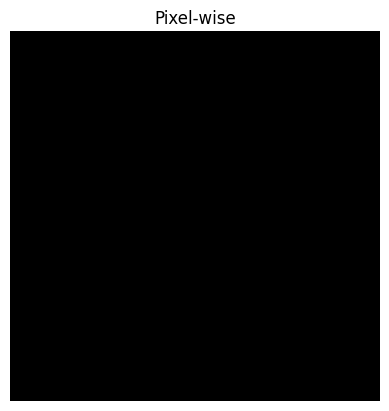


Distortion:
0

PSNR:
inf

SSIM:
1.0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Blue
Pixel wise:


/var/folders/5j/qcktt86s72lf8z5jyddn8yr80000gq/T/ipykernel_71439/416643551.py:43: RuntimeWarning: divide by zero encountered in log
  return 20 * np.log(255) - 10 * np.log(mse)


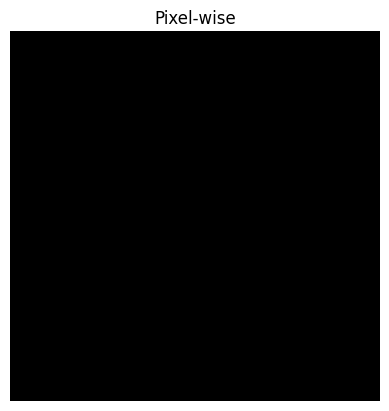


Distortion:
0

PSNR:
inf

SSIM:
1.0
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Color delta


/var/folders/5j/qcktt86s72lf8z5jyddn8yr80000gq/T/ipykernel_71439/416643551.py:9: RuntimeWarning: overflow encountered in scalar subtract
  delta[i,j] = np.sqrt(((g1[i,j,0]-g2[i,j,0])**2)+((g1[i,j,1]-g2[i,j,1])**2)+((g1[i,j,2]-g2[i,j,2])**2))


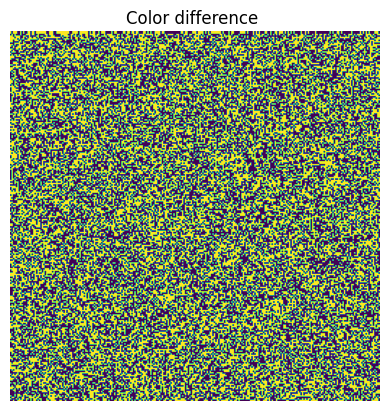

In [23]:
# Compare red
print('---'*30)
print('Red')
compare_images(G3[:,:,0], stego_img_red[:,:,0])
print('---'*30)

# Compare green
print('---'*30)
print('Green')
compare_images(G3[:,:,1], stego_img_red[:,:,1])
print('---'*30)

# Compare blue
print('---'*30)
print('Blue')
compare_images(G3[:,:,2], stego_img_red[:,:,2])
print('---'*30)

# Compare color
print('---'*30)
print('Color delta')
compare_images(G3, stego_img_red, color=True)

Differences are the same, exept that the image is hidden in red color. Other colors aren't impacted.

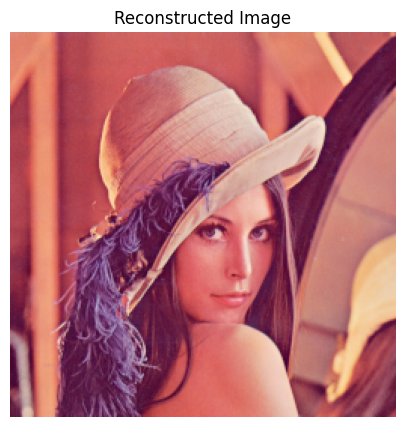

In [24]:
# 3.10 Modify the algorithm in such a way that the secret image is scrambled according to a key

blue_channel = G3[:,:,2]
plane_blue = get_bit_planes(blue_channel)
img_bin = ''.join(G3_secret_bin.flatten().astype(str))

plane_blue = hide_message(img_bin, plane_blue, secret_key)

blue_channel_rec = reconstruct_from_bitplanes(plane_blue)

# Reconstruction of stego image
steg_blue = np.stack((G3[:,:,0], G3[:,:,1], blue_channel_rec),axis=2)

plt.figure(figsize=(10,5))

plt.title('Reconstructed Image')
plt.imshow(steg_blue)
plt.axis('off')

plt.show()

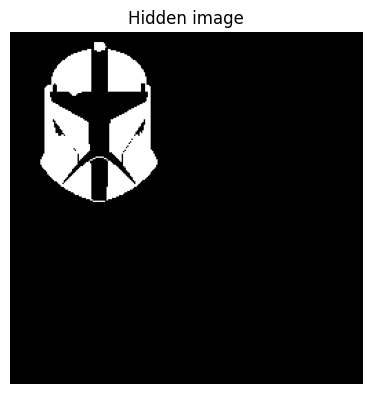

In [39]:
# 3.11 Modify the algorithm so that a smaller image can be embedded

# Grayscale smaller secret image
I_vader = Image.open('clone.png').convert('L')
G_vader = np.array(I_vader)
G_vader_bin = (G_vader > 127).astype(np.uint8)

# Reshape the smaller image to fit the original 
reshaped_vader = np.zeros((G3.shape[0],G3.shape[1]))
reshaped_vader[:G_vader_bin.shape[0], :G_vader_bin.shape[1]] = G_vader_bin

plane_blue_11 = get_bit_planes(G3[:,:,2])
plane_blue_11[:,:,7] = reshaped_vader
blue_channel_11_rec = reconstruct_from_bitplanes(plane_blue_11)

steg_blue_small = np.stack((G3[:,:,0], G3[:,:,1], blue_channel_11_rec),axis=2)

mess_small = get_bit_planes(steg_blue_small[:,:,2])[:,:,7]


plt.figure(figsize=(10,5))

plt.subplot(121).set_title('Hidden image')
plt.imshow(mess_small,cmap='gray')
plt.axis('off')

plt.show()

# of error bits between the original message and extracted message in green channel: 0
# of error bits between the original message and extracted message in blue channel: 0


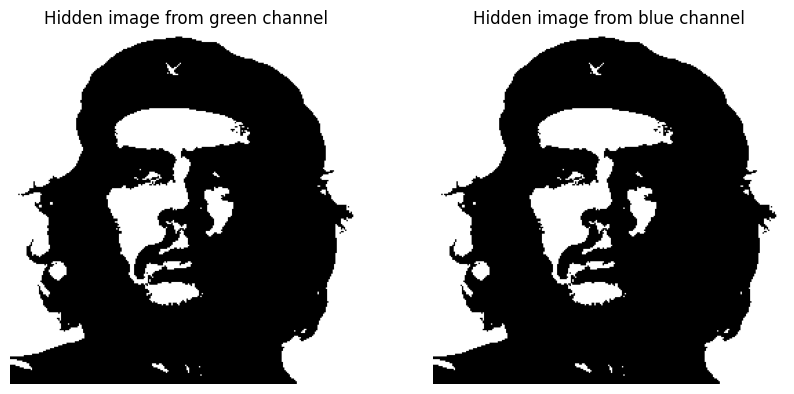

In [26]:
# 3.12. Recover the hidden image

# Green channel
green_channel_steg = stego_img_green[:,:,1]
planes_green_steg = get_bit_planes(green_channel_steg)

# Message on the last bit
message_green = planes_green_steg[:,:,7]

# Compare
mess_green_original = ''.join(G3_secret_bin.flatten().astype(np.uint8).astype(str))
mess_green_modified = ''.join(message_green.flatten().astype(np.uint8).astype(str))
error_green = bin(int(mess_green_original,2) ^ int(mess_green_modified,2)).count('1')
print(f'# of error bits between the original message and extracted message in green channel: {error_green}')

# Blue channel
blue_channel_steg = steg_blue[:,:,2]

# Extract the message with key and L
L3 = blue_channel_steg.shape[0]*blue_channel_steg.shape[1]
message_blue = retrieve_message(blue_channel_steg, L3, secret_key)
message_blue = np.array([int(bit) for bit in message_blue]).reshape(256,256)

# Compare:
mess_blue_original = ''.join(G3_secret_bin.flatten().astype(np.uint8).astype(str))
mess_blue_modified = ''.join(message_blue.flatten().astype(np.uint8).astype(str))
error_blue = bin(int(mess_blue_original,2) ^ int(mess_blue_modified,2)).count('1')
print(f'# of error bits between the original message and extracted message in blue channel: {error_blue}')


plt.figure(figsize=(10,5))

plt.subplot(121).set_title('Hidden image from green channel')
plt.imshow(message_green,cmap='gray')
plt.axis('off')

plt.subplot(122).set_title('Hidden image from blue channel')
plt.imshow(message_blue,cmap='gray')
plt.axis('off')

plt.show()

## Task 4: Embedding of binary image into LSB (robustness)

In [27]:
# 4.1. Explore the effects of various processing on LSB stego images

# Color image
I4 = plt.imread('lena256.png')
I4 = np.array(I4*255).astype(np.uint8)

# Grayscale secret image
S4 = rgb2gray(plt.imread('che.jpg'))
S4 = np.array(S4*255).astype(np.uint8)
S4_BIN = (S4 > 127).astype(np.uint8)

# Red channel
planes_red4 = get_bit_planes(I4[:,:,0])
planes_red4[:,:,7] = S4_BIN
I4_red_rec = reconstruct_from_bitplanes(planes_red4)

# reconstruction of the stego color image
I4_steg = np.stack((I4_red_rec, I4[:,:,1], I4[:,:,2]), axis=2)

# Red channel
planes_red4_scr = get_bit_planes(I4[:,:,0])

# Flatten secret image
s_flat = ''.join(G3_secret_bin.flatten().astype(str))
len_flat_img = len(s_flat)

# Hide message and reconstruct
planes_red4_scr = hide_message(s_flat, planes_red4_scr, secret_key)
I4_red_rec_scr = reconstruct_from_bitplanes(planes_red4_scr)
I4_steg_src = np.stack((I4_red_rec_scr, I4[:,:,1], I4[:,:,2]), axis=2)

# of error bits between the original message and extracted message in red channel with s&p : 5802


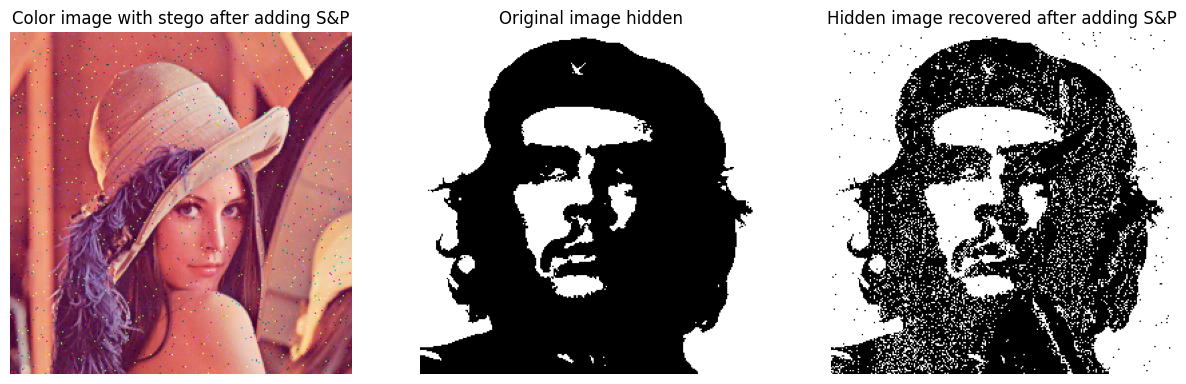

In [28]:
# 4.2. Verify that the secret message (image) is inside the stego image

# Add salt and pepper
I4_steg_snp = random_noise(I4_steg, mode='s&p', amount=0.01)
I4_steg_snp = (I4_steg_snp * 255).astype(np.uint8)

planes_sp = get_bit_planes(I4_steg_snp[:,:,0])
img_sp = planes_sp[:,:,7]

# Compare:
img_original = ''.join(S4_BIN.flatten().astype(np.uint8).astype(str))
img_modified_sp = ''.join(img_sp.flatten().astype(np.uint8).astype(str))
error_sp = bin(int(img_original,2) ^ int(img_modified_sp,2)).count('1')
print(f'# of error bits between the original message and extracted message in red channel with s&p : {error_sp}')


plt.figure(figsize=(15,5))

plt.subplot(131).set_title('Color image with stego after adding S&P')
plt.imshow(I4_steg_snp, cmap='gray')
plt.axis('off')

plt.subplot(132).set_title('Original image hidden')
plt.imshow(S4_BIN, cmap='gray')
plt.axis('off')

plt.subplot(133).set_title('Hidden image recovered after adding S&P')
plt.imshow(img_sp, cmap='gray')
plt.axis('off')

plt.show()

The image was damaged but we can understand the image

# of error bits between the original message and extracted message in red channel with gaussian noise : 65536


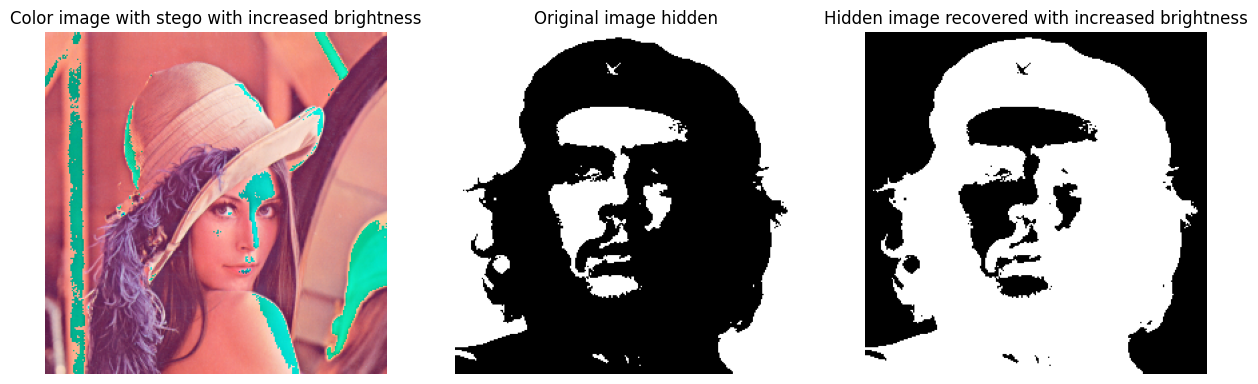

In [29]:
# Increase brighness
I4_steg_brightness = I4_steg + 21
I4_steg_brightness = np.clip(I4_steg_brightness, 0, 255)

planes_bright = get_bit_planes(I4_steg_brightness[:,:,0])
img_bright = planes_bright[:,:,7]

# Compare:
img_original = ''.join(S4_BIN.flatten().astype(np.uint8).astype(str))
img_modified_bright = ''.join(img_bright.flatten().astype(np.uint8).astype(str))
error_bright = bin(int(img_original,2) ^ int(img_modified_bright,2)).count('1')
print(f'# of error bits between the original message and extracted message in red channel with gaussian noise : {error_bright}')


plt.figure(figsize=(15,5))

plt.subplot(131).set_title('Color image with stego with increased brightness')
plt.imshow(I4_steg_brightness, cmap='gray')
plt.axis('off')

plt.subplot(132).set_title(f'Original image hidden')
plt.imshow(S4_BIN, cmap='gray')
plt.axis('off')

plt.subplot(133).set_title(f'Hidden image recovered with increased brightness')
plt.imshow(img_bright, cmap='gray')
plt.axis('off')

plt.show()

After this processing the bits are inverted, but we can understand the image

# of error bits between the original message and extracted message in red channel with cropping : 31538


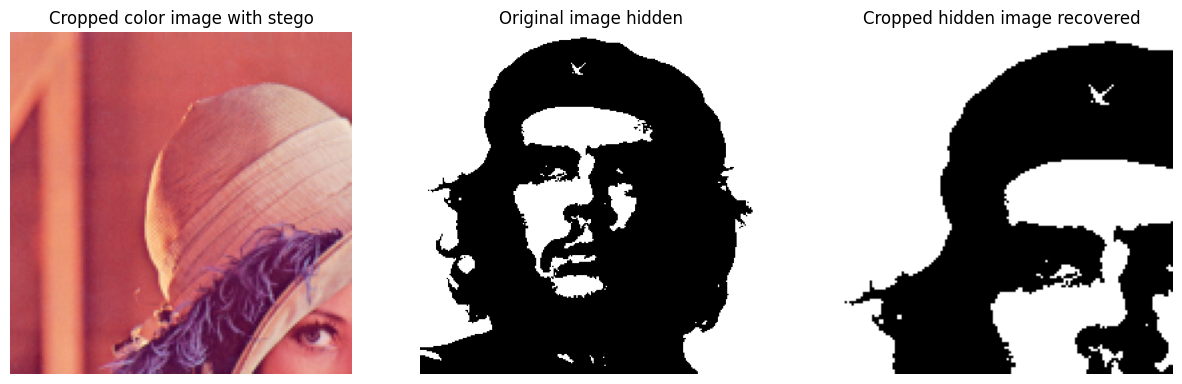

In [30]:
# 4.3. Crop an arbitrary portion of the image and verify what happens to the LSB message. What if the message was scrambled at embedding?

# Cropped image
I4_steg_cropped = I4_steg[0:150,0:150]

planes_crops = get_bit_planes(I4_steg_cropped[:,:,0])
img_crop = planes_crops[:,:,7]

# Compare:
img_original = ''.join(S4_BIN.flatten().astype(np.uint8).astype(str))
img_modified_crop = ''.join(img_crop.flatten().astype(np.uint8).astype(str))
error_crop = bin(int(img_original,2) ^ int(img_modified_crop,2)).count('1')
print(f'# of error bits between the original message and extracted message in red channel with cropping : {error_crop}')


plt.figure(figsize=(15,5))

plt.subplot(131).set_title('Cropped color image with stego')
plt.imshow(I4_steg_cropped, cmap='gray')
plt.axis('off')

plt.subplot(132).set_title('Original image hidden')
plt.imshow(S4_BIN, cmap='gray')
plt.axis('off')

plt.subplot(133).set_title('Cropped hidden image recovered')
plt.imshow(img_crop, cmap='gray')
plt.axis('off')

plt.show()

As expected the secret image was also cropped

# of error bits between original message and extracted message in red channel with cropping : 30304


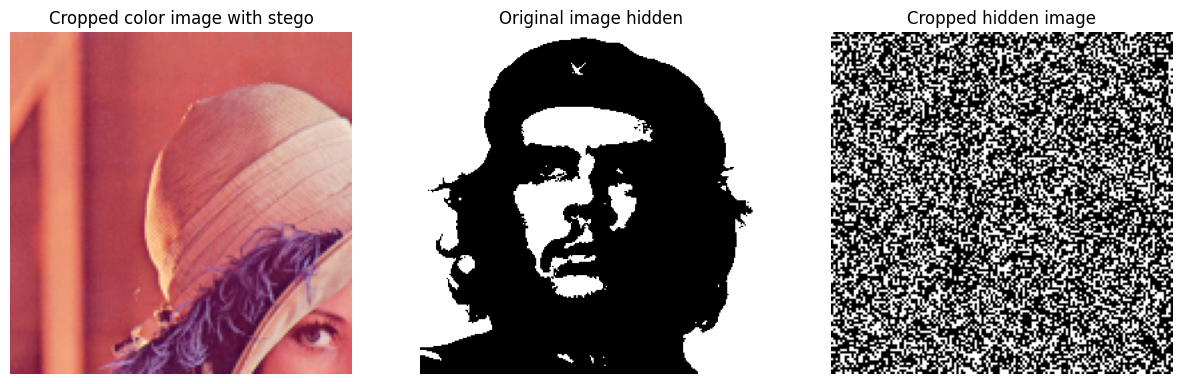

In [31]:
# Cropped image 
I4_steg_cropped_src = I4_steg_src[0:150,0:150]

# Extract message
L4_src = I4_steg_cropped_src.shape[0]*I4_steg_cropped_src.shape[1]

img_crop_scr = retrieve_message(I4_steg_cropped_src[:,:,0], L4_src, secret_key)
img_crop_scr = np.array([int(bit) for bit in img_crop_scr]).reshape(150,150)

# Compare:
img_original = ''.join(S4_BIN.flatten().astype(np.uint8).astype(str))
img_modified_crop_scr = ''.join(img_crop_scr.flatten().astype(np.uint8).astype(str))
error_crop_scr = bin(int(img_original,2) ^ int(img_modified_crop_scr,2)).count('1')
print(f'# of error bits between original message and extracted message in red channel with cropping : {error_crop_scr}')


plt.figure(figsize=(15,5))

plt.subplot(131).set_title('Cropped color image with stego')
plt.imshow(I4_steg_cropped_src, cmap='gray')
plt.axis('off')

plt.subplot(132).set_title('Original image hidden')
plt.imshow(S4_BIN, cmap='gray')
plt.axis('off')

plt.subplot(133).set_title('Cropped hidden image')
plt.imshow(img_crop_scr, cmap='gray')
plt.axis('off')

plt.show()

With scrambled we can't retrieve original hidden image, because we miss a lot of pixels in random positions

# of error bits between the original message and extracted message in red channel with gaussian noise : 33690


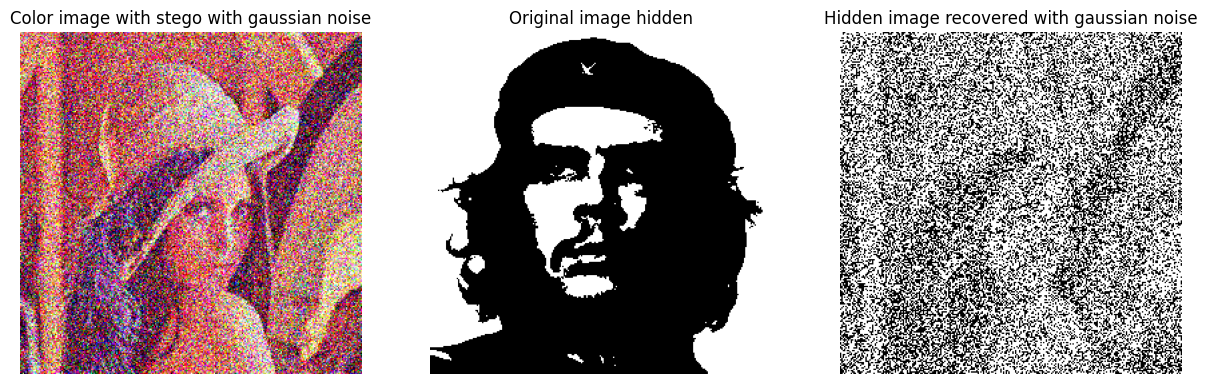

In [32]:
# 4.4. Add some noise to the stego image and verify what happens to the LSB message

# Add gaussian noise
I4_steg_gauss = random_noise(I4_steg, mode='gaussian', mean=0, var = 0.1)
I4_steg_gauss = (I4_steg_gauss * 255).astype(np.uint8)

planes_gauss = get_bit_planes(I4_steg_gauss[:,:,0])
img_gauss = planes_gauss[:,:,7]

# Compare:
img_original = ''.join(S4_BIN.flatten().astype(np.uint8).astype(str))
img_modified_gauss = ''.join(img_gauss.flatten().astype(np.uint8).astype(str))
error_gauss = bin(int(img_original,2) ^ int(img_modified_gauss,2)).count('1')
print(f'# of error bits between the original message and extracted message in red channel with gaussian noise : {error_gauss}')


plt.figure(figsize=(15,5))

plt.subplot(131).set_title('Color image with stego with gaussian noise')
plt.imshow(I4_steg_gauss, cmap='gray')
plt.axis('off')

plt.subplot(132).set_title('Original image hidden')
plt.imshow(S4_BIN, cmap='gray')
plt.axis('off')

plt.subplot(133).set_title('Hidden image recovered with gaussian noise')
plt.imshow(img_gauss, cmap='gray')
plt.axis('off')

plt.show()

Because of the gaussian noise property we can't retrieve the hidden image

# of error bits between the original message and extracted message in red channel with jpeg compression : 32684


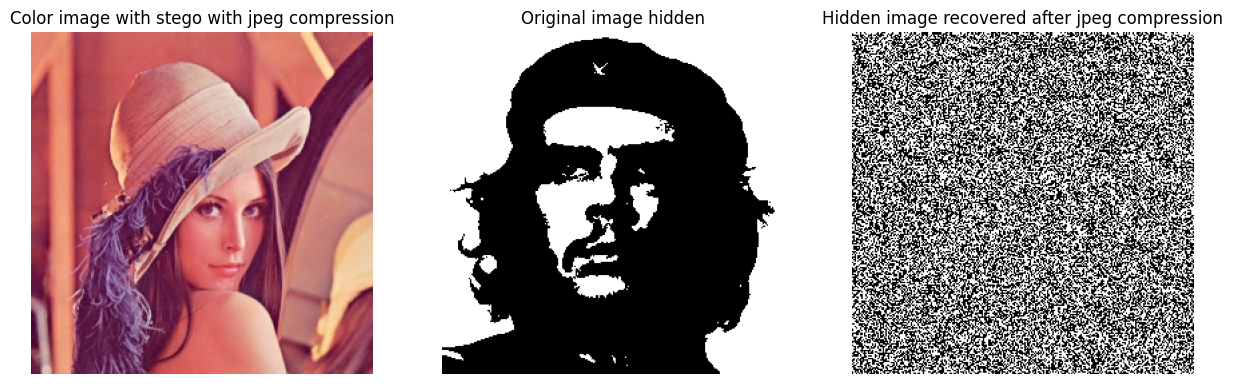

In [33]:
# 4.5. Compress the image with JPEG and verify what happens to the LSB message

# Create jpeg
I4_steg_jpeg = Image.fromarray(I4_steg)
I4_steg_jpeg.save('lena256_task4.jpeg', 'JPEG', quality=100)
I4_steg_jpeg = plt.imread('lena256_task4.jpeg')

planes_jpeg = get_bit_planes(I4_steg_jpeg[:,:,0])
img_jpeg = planes_jpeg[:,:,7]

# Compare:
img_original = ''.join(S4_BIN.flatten().astype(np.uint8).astype(str))
img_modified_jpeg = ''.join(img_jpeg.flatten().astype(np.uint8).astype(str))
error_jpg = bin(int(img_original,2) ^ int(img_modified_jpeg,2)).count('1')
print(f'# of error bits between the original message and extracted message in red channel with jpeg compression : {error_jpg}')


plt.figure(figsize=(15,5))

plt.subplot(131).set_title('Color image with stego with jpeg compression')
plt.imshow(I4_steg_jpeg, cmap='gray')
plt.axis('off')

plt.subplot(132).set_title('Original image hidden')
plt.imshow(S4_BIN, cmap='gray')
plt.axis('off')

plt.subplot(133).set_title('Hidden image recovered after jpeg compression')
plt.imshow(img_jpeg, cmap='gray')
plt.axis('off')

plt.show()

Even with quality 100, the hidden message is lost

## Embedding of binary image into LSB (detection)

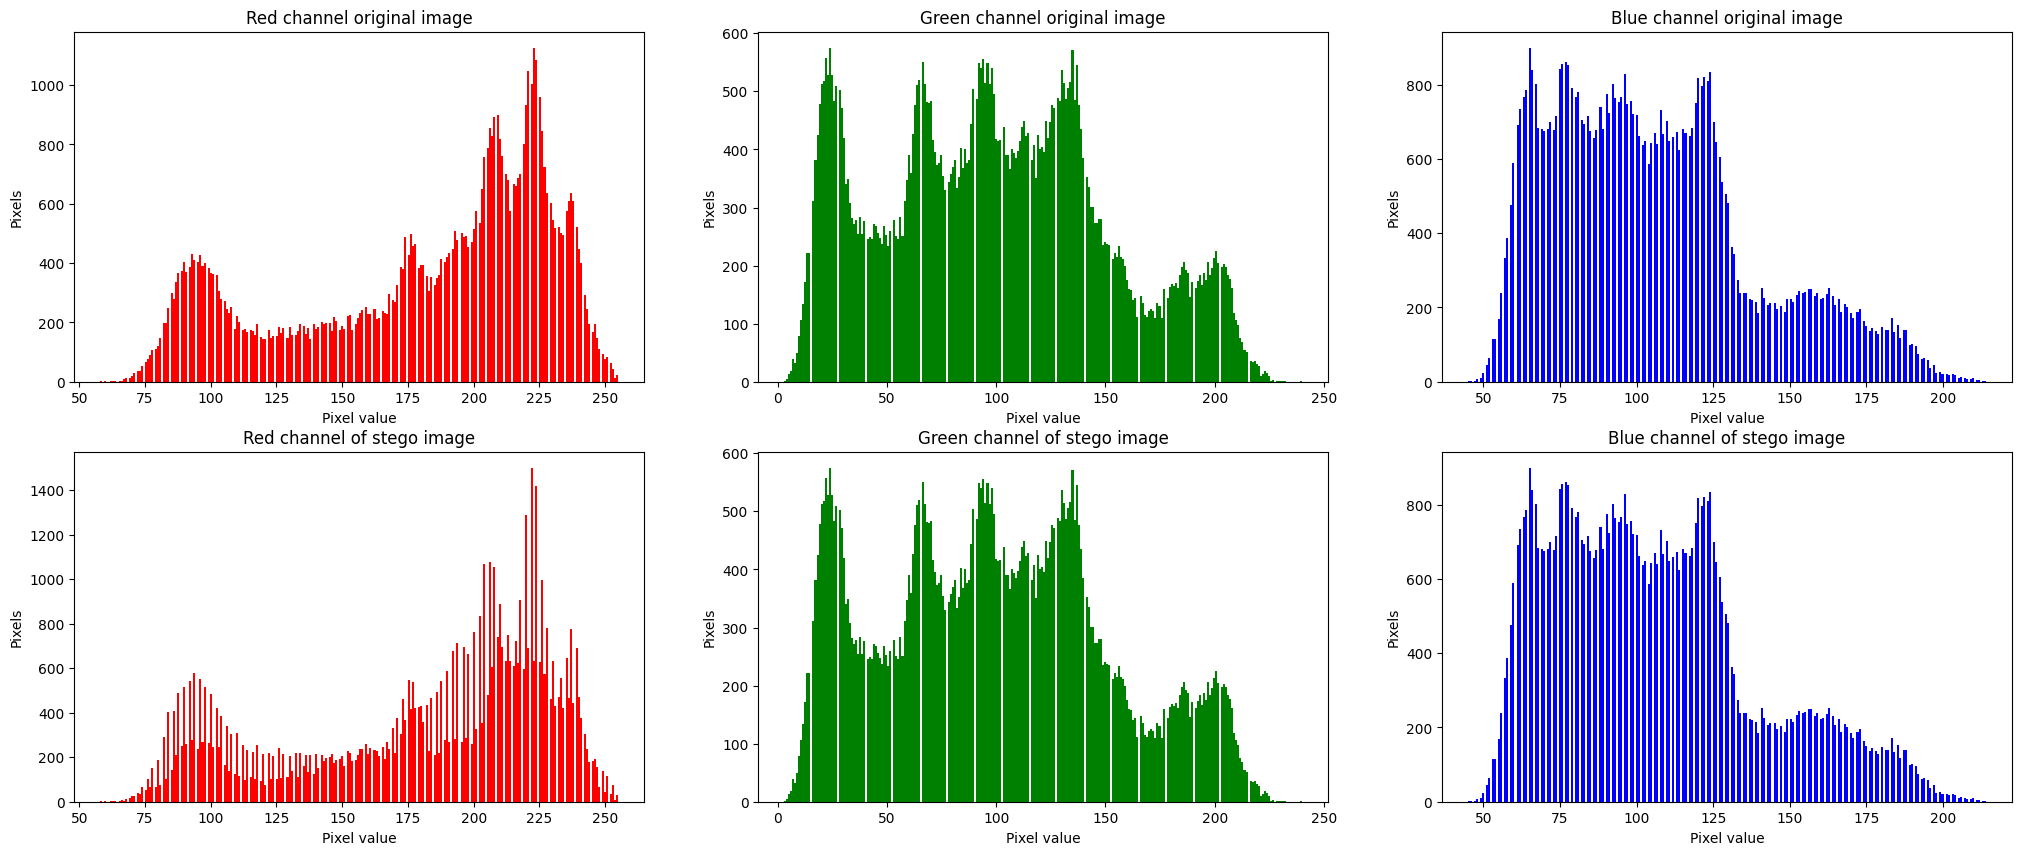

In [34]:
# 5.1. LSB embedding leaves traces into image histogram

# Original image
I5 = plt.imread('lena256.png')
I5 = np.array(I5*255).astype(np.uint8)

# Frayscale secret image
S5 = rgb2gray(plt.imread('che.jpg'))
S5 = np.array(S5*255).astype(np.uint8)
S5_BIN = (S5 > 127).astype(np.uint8)

planes_red5 = get_bit_planes(I5[:,:,0])
planes_red5[:,:,7] = S5_BIN
I5_red_rec = reconstruct_from_bitplanes(planes_red5)

# Reconstruct
I5_steg = np.stack((I4_red_rec, I5[:,:,1], I5[:,:,2]), axis=2)


plt.figure(figsize=(25,10))

plt.subplot(231).set_title('Red channel original image')
plt.hist(I5[:,:,0].ravel(), bins=256, color='Red')
plt.xlabel("Pixel value")
plt.ylabel("Pixels")

plt.subplot(232).set_title('Green channel original image')
plt.hist(I5[:,:,1].ravel(), bins=256, color='Green')
plt.xlabel("Pixel value")
plt.ylabel("Pixels")

plt.subplot(233).set_title('Blue channel original image')
plt.hist(I5[:,:,2].ravel(), bins=256, color='Blue')
plt.xlabel("Pixel value")
plt.ylabel("Pixels")

plt.subplot(234).set_title(f'Red channel of stego image')
plt.hist(I5_steg[:,:,0].ravel(), bins=256, color='Red')
plt.xlabel("Pixel value")
plt.ylabel("Pixels")

plt.subplot(235).set_title(f'Green channel of stego image')
plt.hist(I5_steg[:,:,1].ravel(), bins=256, color='Green')
plt.xlabel("Pixel value")
plt.ylabel("Pixels")

plt.subplot(236).set_title(f'Blue channel of stego image')
plt.hist(I5_steg[:,:,2].ravel(), bins=256, color='Blue')
plt.xlabel("Pixel value")
plt.ylabel("Pixels")

plt.show()

In [35]:
# 5.2. Read the color stego image from Task 3, extract the green channel hosting the LSB secret message

img_task3 = np.array(Image.open('lena256_task3_green.tiff'))
img_task3_green = img_task3[:,:,1]

We can observe missing peacks on the red histogram

In [36]:
# 5.3. Compute the pixel histogram of the original green channel and of the stego green channel



In [37]:
# 5.4. Plot the histograms and observe their differences



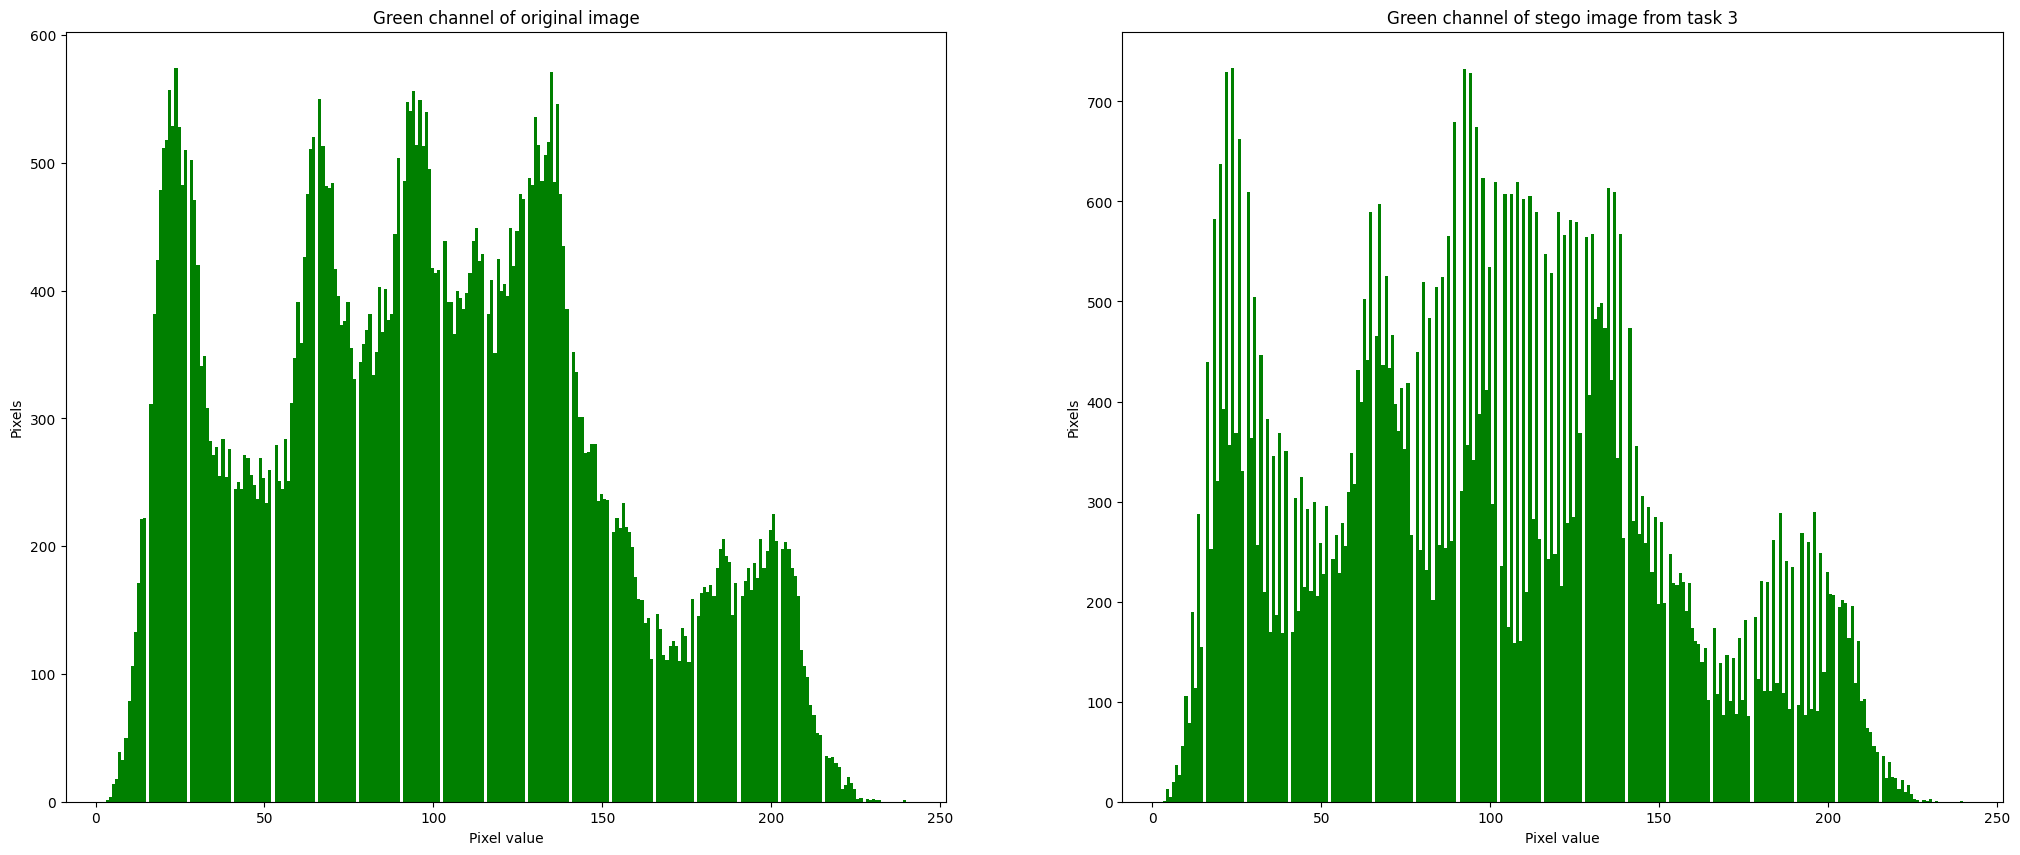

In [38]:
# 5.5. LSB revealed by LSB enhancement

plt.figure(figsize=(25,10))

plt.subplot(121).set_title(f'Green channel of original image')
plt.hist(I5[:,:,1].ravel(), bins=256, color='Green')
plt.xlabel("Pixel value")
plt.ylabel("Pixels")

plt.subplot(122).set_title(f'Green channel of stego image from task 3')
plt.hist(img_task3_green.ravel(), bins=256, color='Green')
plt.xlabel("Pixel value")
plt.ylabel("Pixels")

plt.show()


We can make the similar observations here